notebook to plot the 2D maps of the 3D dust map projected onto/across various planes

probably want to play with adjusting the colormaps + fontsizes a bit

In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import coordinate_transform_functions as ct

In [2]:
hdul = fits.open('data/cube_ext.fits')
data = hdul[0].data
hdul.close()

In [3]:
sunpos = np.array((300.5, 300.5, 40.5))
gridstep = 10

In [4]:
# convert Cyg OB2 coords copied from SIMBAD to decimal degrees
CygOB2_coords = SkyCoord('20 33 12.0 +41 19 00', unit=(u.hourangle, u.deg))

CygOB2_datax, CygOB2_datay, CygOB2_dataz = ct.radec_to_data(CygOB2_coords.ra.value, CygOB2_coords.dec.value, 1593)
print(f'x: {CygOB2_datax}, y: {CygOB2_datay}, z: {CygOB2_dataz}')

x: 327.55586682756666, y: 457.4699490316298, z: 42.71476211284746


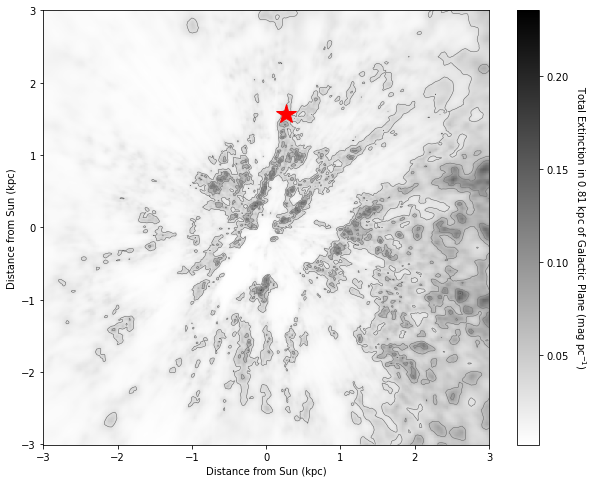

In [5]:
# test plot of total extinction in the plane parallel to the Galactic plane, in physical units (kpc)
# Cyg OB2 location in this projection is indicated with a red star
flat = np.sum(data, axis=0)
x = np.arange(0, data.shape[2], 1) + 0.5
y = np.arange(0, data.shape[1], 1) + 0.5
x_kpc = (x - sunpos[0]) * gridstep / 1000
y_kpc = (y - sunpos[1]) * gridstep /1000
xx_kpc, yy_kpc = np.meshgrid(x_kpc, y_kpc)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xx_kpc, yy_kpc, flat, cmap='binary')
ax.contour(xx_kpc, yy_kpc, flat, cmap='gray', linewidths=0.5, alpha=0.7)
ax.plot((CygOB2_datax - sunpos[0]) * gridstep / 1000, (CygOB2_datay - sunpos[0]) * gridstep / 1000, c='r', marker='*', ms=20)
ax.set_xlabel('Distance from Sun (kpc)')
ax.set_ylabel('Distance from Sun (kpc)')
cb = fig.colorbar(im, ax=ax)
cb.set_label(f'Total Extinction in {gridstep*data.shape[0]/1000} kpc of Galactic Plane '+r'(mag pc$^{-1}$)', rotation=-90, va='bottom')
plt.show()

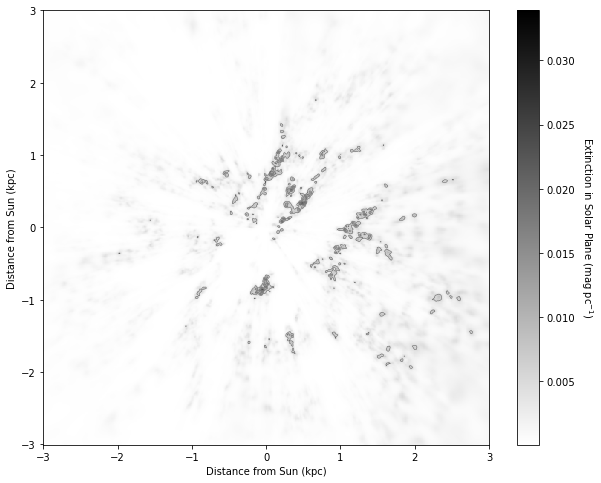

In [6]:
# plot of extinction in the solar plane only, in physical units (kpc)
solarplane = data[int(np.floor(sunpos[2]))]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xx_kpc, yy_kpc, solarplane, cmap='binary')
ax.contour(xx_kpc, yy_kpc, solarplane, cmap='gray', linewidths=0.5, alpha=0.7)
ax.set_xlabel('Distance from Sun (kpc)')
ax.set_ylabel('Distance from Sun (kpc)')
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'Extinction in Solar Plane (mag pc$^{-1}$)', rotation=-90, va='bottom')
plt.show()

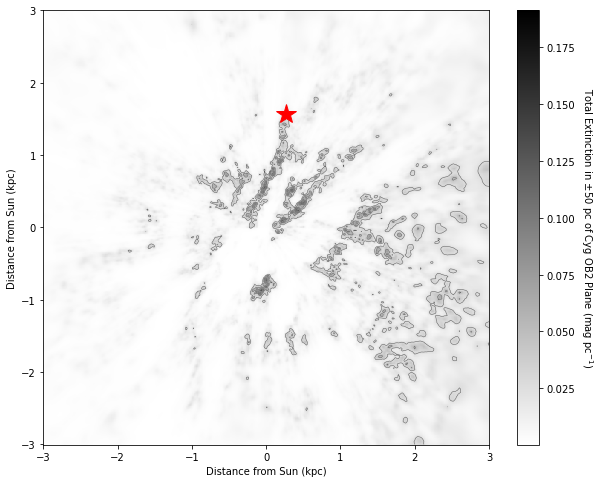

In [7]:
# plot of extinction in the plane of Cyg OB2, in physical units (kpc) (+/-50 pc from z coord of Cyg OB2)
# Cyg OB2 location indicated with a red star

z_extent = 50. / gridstep # 50 pc in data units
inds = int(np.floor(CygOB2_dataz - z_extent)), int(np.ceil(CygOB2_dataz + z_extent))
flat2 = np.sum(data[inds[0]:inds[1]], axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xx_kpc, yy_kpc, flat2, cmap='binary')
ax.contour(xx_kpc, yy_kpc, flat2, cmap='gray', linewidths=0.5, alpha=0.7)
ax.plot((CygOB2_datax - sunpos[0]) * gridstep / 1000, (CygOB2_datay - sunpos[0]) * gridstep / 1000, c='r', marker='*', ms=20)
ax.set_xlabel('Distance from Sun (kpc)')
ax.set_ylabel('Distance from Sun (kpc)')
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'Total Extinction in $\pm$50 pc of Cyg OB2 Plane (mag pc$^{-1}$)', rotation=-90, va='bottom')
plt.show()

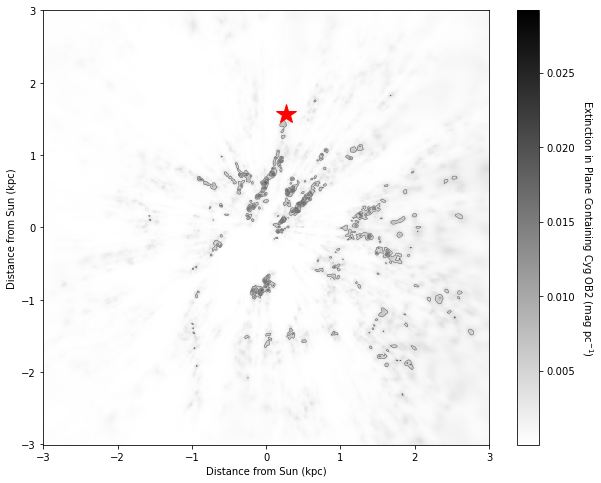

In [8]:
# plot of extinction in the solar plane only, in physical units (kpc)
CygOB2plane = data[int(np.floor(CygOB2_dataz))]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xx_kpc, yy_kpc, CygOB2plane, cmap='binary')
ax.contour(xx_kpc, yy_kpc, CygOB2plane, cmap='gray', linewidths=0.5, alpha=0.7)
ax.plot((CygOB2_datax - sunpos[0]) * gridstep / 1000, (CygOB2_datay - sunpos[0]) * gridstep / 1000, c='r', marker='*', ms=20)
ax.set_xlabel('Distance from Sun (kpc)')
ax.set_ylabel('Distance from Sun (kpc)')
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'Extinction in Plane Containing Cyg OB2 (mag pc$^{-1}$)', rotation=-90, va='bottom')
plt.show()

In [9]:
def line_from_2_points(x, p1, p2):
    """
    Calculates the equation of a line defined by two points p1 and p2
    Evaluates the line for values in x and returns y
    
    Parameters
    ----------
    x : array of floats
        x-coordinates to evaluate line over
    p1 : 2-tuple
         first point on line, with p1 = (x1, y1)
    p2 : 2-tuple
         secon point on line, with p2 = (x2, y2)
        
    Returns
    -------
    y : array of floats
        y values of line
    """
    slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
    return p2[1] + (slope * (x-p2[0]))

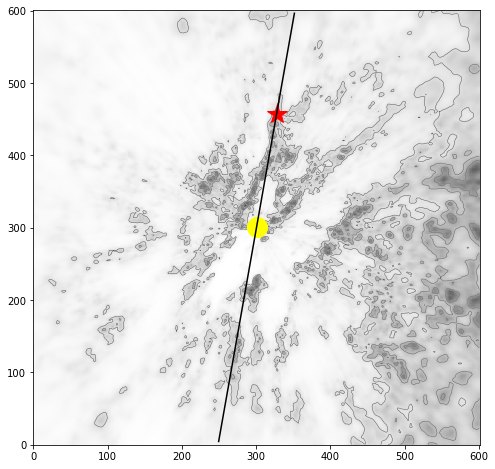

In [48]:
sun_CygOB2_line_y = line_from_2_points(x, (sunpos[0], sunpos[1]), (CygOB2_datax, CygOB2_datay))
line_xinds_on_grid = np.where((sun_CygOB2_line_y>y.min()) & (sun_CygOB2_line_y<y.max()+1))[0]
line_yinds_on_grid = np.searchsorted(y, sun_CygOB2_line_y[line_xinds_on_grid])

xx, yy = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(xx, yy, flat, cmap='binary')
ax.contour(xx, yy, flat, cmap='gray', linewidths=0.5, alpha=0.7)
ax.plot(sunpos[0], sunpos[1], c='yellow', marker='o', ms=20)
ax.plot(CygOB2_datax, CygOB2_datay, c='r', marker='*', ms=20)
ax.plot(x[line_xinds_on_grid], sun_CygOB2_line_y[line_xinds_on_grid], c='k')
plt.show()

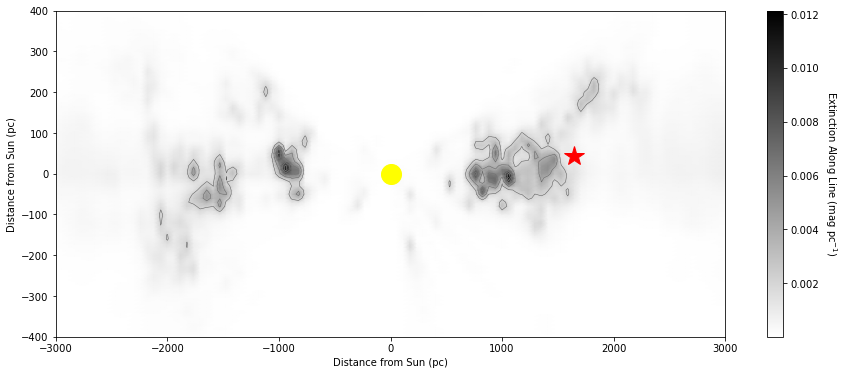

In [128]:
flattened_data_along_line = np.empty((data.shape[0], len(line_xinds_on_grid)))
for i in range(len(line_xinds_on_grid)):
    flattened_data_along_line[:,i] = data[:,line_yinds_on_grid][:,:,line_xinds_on_grid][:,i,i]

sun_ind_along_line = np.searchsorted(x[line_xinds_on_grid], sunpos[0])
CygOB2_ind_along_line = np.searchsorted(x[line_xinds_on_grid], CygOB2_datax)

# figure out how many data units per step along the line
points_along_line_scale = np.sqrt(np.diff(x[line_xinds_on_grid])[0]**2 + np.diff(sun_CygOB2_line_y[line_xinds_on_grid])[0]**2)

points_along_line = (np.arange(0, len(line_xinds_on_grid), 1) + 0.5) * points_along_line_scale
z = np.arange(0, data.shape[0], 1) + 0.5

points_along_line_pc = (points_along_line - points_along_line[sun_ind_along_line]) * gridstep
z_pc = (z - sunpos[2]) * gridstep

#linemesh, zz = np.meshgrid(points_along_line, z)
linemesh_pc, zz_pc = np.meshgrid(points_along_line_pc, z_pc)

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.pcolormesh(linemesh_pc, zz_pc, flattened_data_along_line, cmap='binary', shading='gouraud')
ax.contour(linemesh_pc, zz_pc, flattened_data_along_line, cmap='gray', linewidths=0.5, alpha=0.7)
ax.plot(0, 0, c='yellow', marker='o', ms=20)
ax.plot(points_along_line_pc[CygOB2_ind_along_line], CygOB2_dataz, c='r', marker='*', ms=20)
ax.set_xlabel('Distance from Sun (pc)')
ax.set_ylabel('Distance from Sun (pc)')
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'Extinction Along Line (mag pc$^{-1}$)', rotation=-90, va='bottom')